策略梯度算法

In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import rl_utils
import os
import env
env = env.DroneEnv()
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

C:\Users\10749\anaconda3\envs\PyTorch\lib\site-packages\gym\spaces\box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


# 定义自定义 softmax 函数
def custom_softmax(x):
    with torch.no_grad():
        x_cpu = x.cpu().detach().numpy()
        e_x = np.exp(x_cpu - np.max(x_cpu))
        result = torch.from_numpy(e_x / e_x.sum()).float().cuda()
        print(result)
        return result.requires_grad_()

In [2]:
 def clamp_probs(probs):
        eps = torch.finfo(probs.dtype).eps  # 获取probs对应的dtype数据类型使得1.0 + eps != 1.0 的最小值
        return probs.clamp(min=0.01, max=1 - 0.01)  # 对probs进行处理，probs的最小值为eps，最大值为1-eps

class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        #print(torch.tanh(self.fc2(x)))
        #print(F.softmax(torch.tanh(self.fc2(x)), dim=1))
        return F.softmax(torch.tanh(self.fc2(x)), dim=1)

In [3]:
class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 device):
        self.policy_net = PolicyNet(state_dim, hidden_dim,
                                    action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(),
                                          lr=learning_rate)  # 使用Adam优化器
        self.gamma = gamma  # 折扣因子
        self.device = device
        
#take_action 方法：这个方法根据策略网络的动作概率分布随机采样一个动作。它接受当前状态作为输入，并返回一个动作。
    def take_action(self, state, last):  # 根据动作概率分布随机采样，
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.policy_net(state)     #它接受状态作为输入，并输出一个概率分布，表示在当前状态下采取每个可能动作的概率。
        #torch.distributions.Categorical 实例化时需要一个概率张量作为参数，它会将这些概率用于创建一个离散的分布。
        #可以通过调用 action_dist.sample() 来从中采样一个动作。
        #print(probs)
        probs = clamp_probs(probs)
        if last:
            return probs.argmax().item()
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']

        G = 0
        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))):  # 从最后一步算起
            reward = reward_list[i]
            state = torch.tensor([state_list[i]],
                                 dtype=torch.float).to(self.device)
            action = torch.tensor([action_list[i]]).view(-1, 1).to(self.device)
            log_prob = torch.log(self.policy_net(state).gather(1, action))
            #它从第1维（通常是列维度，因为PyTorch的索引从0开始）中收集了特定动作 action 的概率值。


            G = self.gamma * G + reward
            loss = -log_prob * G  # 每一步的损失函数
            #print(loss)
            loss.backward()  # 反向传播计算梯度
        self.optimizer.step()  # 梯度下降

Iteration 0: 100%|██████████| 100/100 [02:14<00:00,  1.43s/it, episode=100, return=-17335.031]

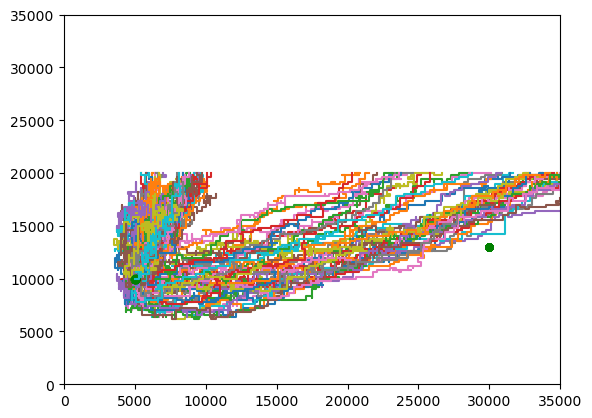

Iteration 1: 100%|██████████| 100/100 [02:18<00:00,  1.20s/it, episode=200, return=-4675.382]

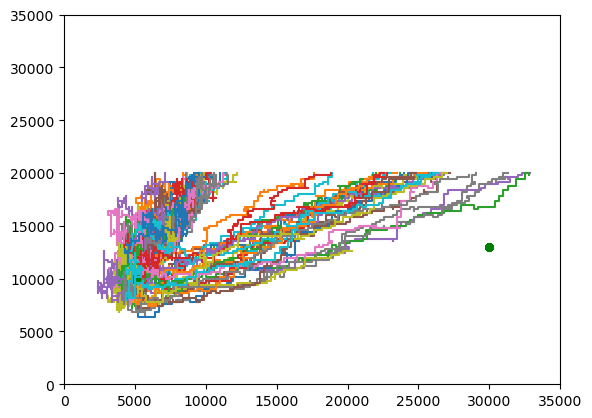

Iteration 2: 100%|██████████| 100/100 [01:52<00:00,  1.03s/it, episode=300, return=-1621.772]

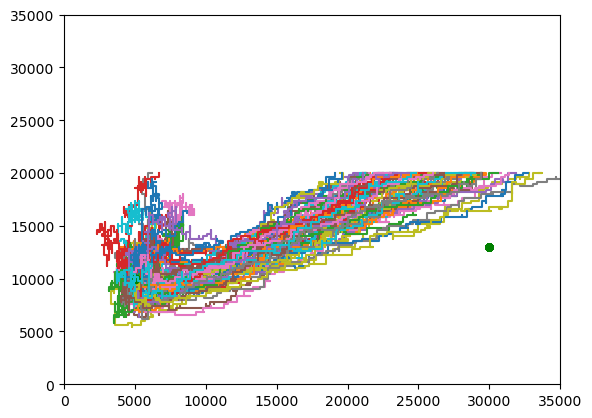

Iteration 3: 100%|██████████| 100/100 [01:54<00:00,  1.42s/it, episode=400, return=-3145.250]

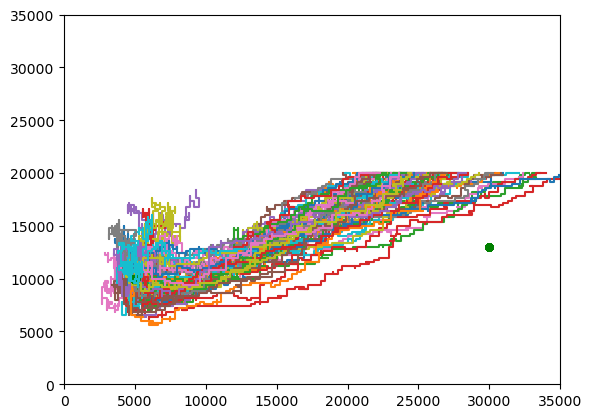

Iteration 4: 100%|██████████| 100/100 [02:19<00:00,  1.75s/it, episode=500, return=-6127.636]

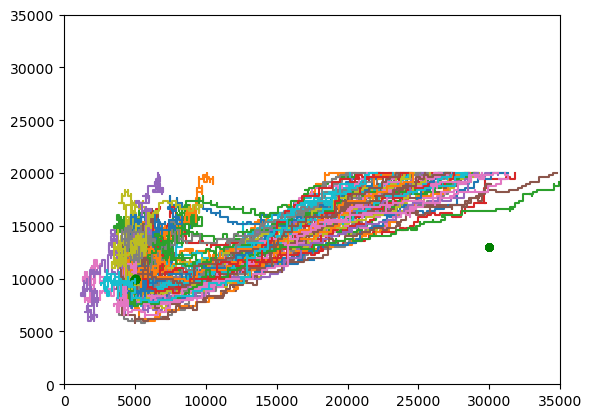

Iteration 5: 100%|██████████| 100/100 [01:53<00:00,  1.15it/s, episode=600, return=-982.670]

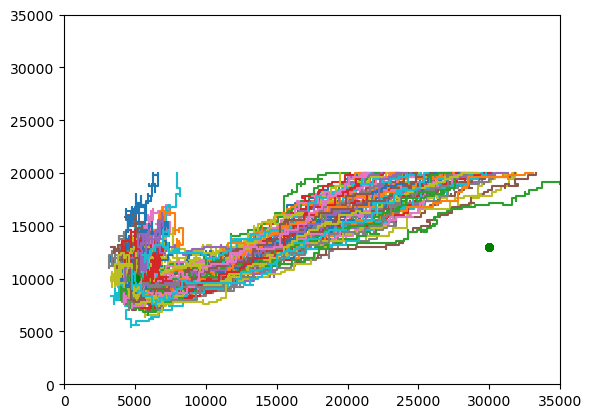

Iteration 6: 100%|██████████| 100/100 [01:50<00:00,  1.46s/it, episode=700, return=-2297.226]

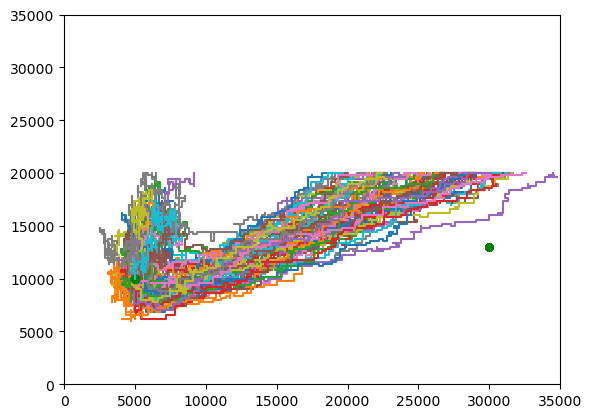

Iteration 7: 100%|██████████| 100/100 [01:53<00:00,  1.16it/s, episode=800, return=-3868.564]

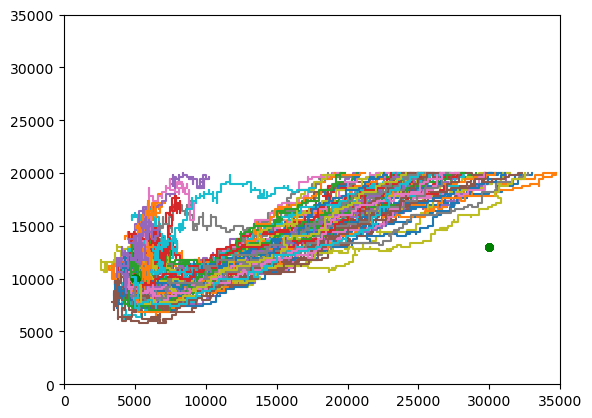

Iteration 8: 100%|██████████| 100/100 [01:53<00:00,  1.27s/it, episode=900, return=-5612.488]

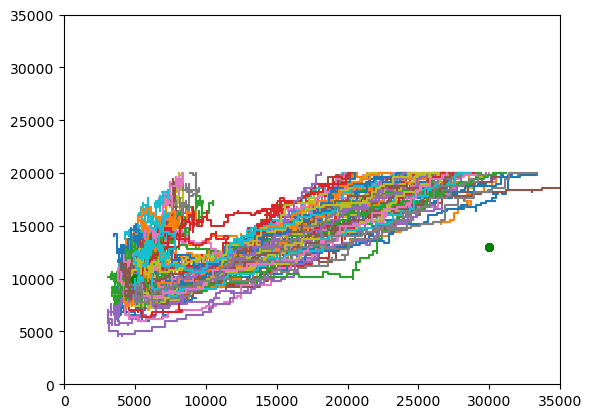

Iteration 9: 100%|██████████| 100/100 [02:00<00:00,  1.01it/s, episode=1000, return=-5861.196]

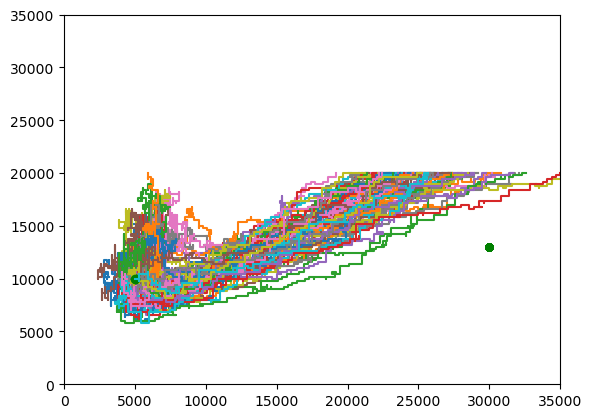

Iteration 9: 100%|██████████| 100/100 [02:01<00:00,  1.21s/it, episode=1000, return=-5861.196]


In [4]:
learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.1
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

#env_name = "CartPole-v0"
#env = gym.make(env_name)
#env.seed(0)
torch.manual_seed(1)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma,
                  device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            state = env.reset()
            done = False
            count = 0
            #绘制x,y轴
            X=[]
            Y=[]
            while not done:
                X.append(state[0])
                Y.append(state[1])
                count += 1
                action = agent.take_action(state,False)
                next_state, reward, done, _ = env.step(action)
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                #print(action,state,reward)
                episode_return += reward
                if (count>500):
                    done = True
            #画图可视化
            plt.plot(5000, 10000, 'go')  # 'ro'表示红色的点
            plt.plot(30000, 13000, 'go',markersize=env.r_goal*0.1)  # 'ro'表示红色的点
            #plt.plot(50, 50, 'ro',markersize=env.r_obstacles)#障碍物
            plt.xlim(0, 35000)
            plt.ylim(0, 35000)
            plt.plot(X,Y)
            return_list.append(episode_return)#一条序列的return
            agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)
        plt.show()


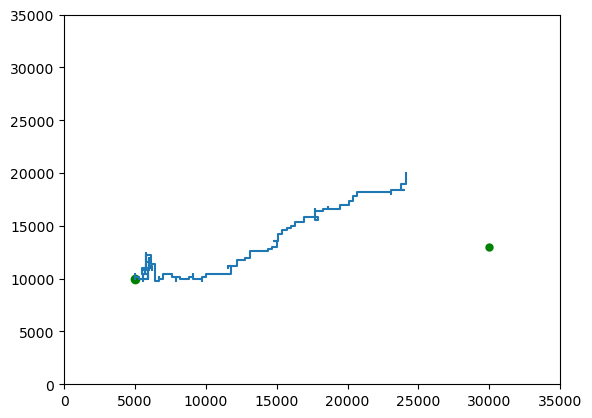

In [5]:
state = env.reset()
done = False
 #绘制x,y轴
X=[]
Y=[]
while not done:
    #print(state)
    X.append(state[0])
    Y.append(state[1])
    #print(state)
    action = agent.take_action(state,False)
    #print(state)
    next_state, reward, done, _ = env.step(action)
    #print(state,action,next_state)
    state = next_state
#画图可视化
plt.plot(5000, 10000, 'go')  # 'ro'表示红色的点
plt.plot(30000, 13000, 'go',markersize=env.r_goal*0.1)  # 'ro'表示红色的点
            #plt.plot(50, 50, 'ro',markersize=env.r_obstacles)#障碍物
plt.xlim(0, 35000)
plt.ylim(0, 35000)
plt.plot(X,Y)

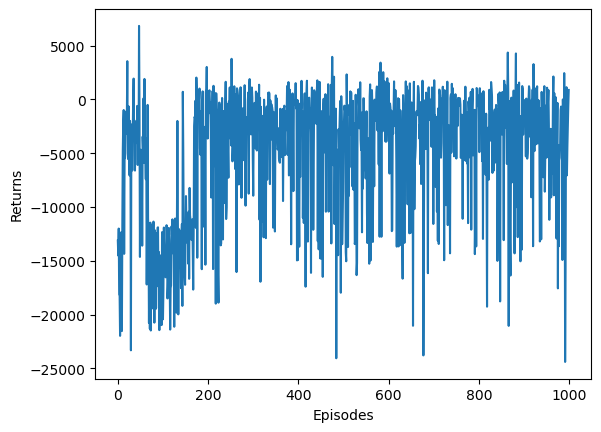

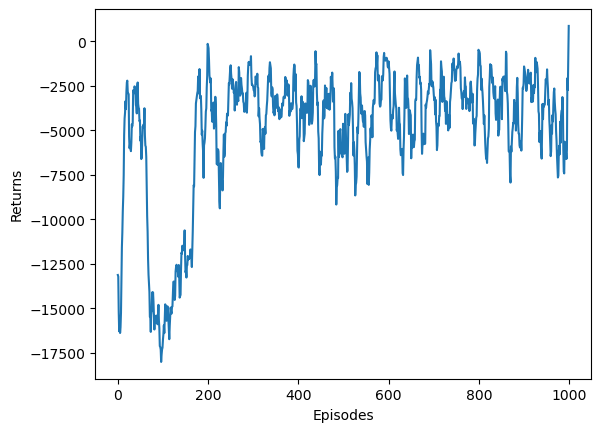

In [6]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
#plt.title('REINFORCE on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
#plt.title('REINFORCE on {}'.format(env_name))
plt.show()